### Code Practice


Data:
This dataset is from a UK retailer and can be downloaded from Kaggle. The dataset ranges from 2008 to 2011.

Desciption of variables:
* InvoiceDate- Date and time of the purchase.
* InvoiceNo - Invoice identification number.
* StockCode- Stock code for the product.
* Description - Brief description of the product.
* Quantity - Quantity of items purchased.
* UnitPrice - Unit price for a given product in Pounds Sterling.
* CurtomerID - ID of the customer making the purchase.
* Country - Country where the purchase was made.

In [1]:
import io
import numpy as np
import pandas as pd
import datetime as dt
import pandas_datareader.data as web

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from plotnine import *

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

import statistics as st
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error

c:\Users\Youyoung\Documents\awesome-timeseries-forecasting\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
Importing plotly failed. Interactive plots will not work.


In [8]:
df = pd.read_csv('files/sales_data.csv', encoding='latin-1')

In [9]:
# preprocess
df.index = pd.to_datetime(df['InvoiceDate'], infer_datetime_format=True)
df = df.drop('InvoiceDate', axis=1)

# here just remove missing values
df = df.dropna(axis=0)

# we know that quantity and unit price cannot be zero
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]

# create a total amt column
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

In [10]:
df.head(2)

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,TotalAmount
InvoiceDate,,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,15.30
2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,20.34


In [11]:
# creating new features to help with the Time Series Analysis
df["Year"] = df.index.year 
df["Quarter"] = df.index.quarter
df["Month"] = df.index.month
df["Week"] = df.index.week
df["Weekday"] = df.index.weekday
df["Day"] = df.index.day
df["Dayofyear"] = df.index.dayofyear
df["Date"] = pd.DatetimeIndex(df.index).date

C:\Users\Youyoung\AppData\Local\Temp\ipykernel_16648\670903528.py:5: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)


In [12]:
df.head(2)

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,TotalAmount,Year,Quarter,Month,Week,Weekday,Day,Dayofyear,Date
InvoiceDate,,,,,,,,,,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,15.30,2010,4,12,48,2,1,335,2010-12-01
2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,20.34,2010,4,12,48,2,1,335,2010-12-01


We are going to focus on the variable for daily total amount. But we need to group it first based on dates. For that, we'll create a vector with variables that we'll use for grouping. To keep track of the amount spent, we'll also group the "TotalAmount" variable

In [28]:
# group by quantity and total amount
cols = ["Date", "Year", "Quarter","Month", "Week", "Weekday", "Dayofyear", "Day", "StockCode"]

df2 = pd.DataFrame(df.groupby(cols)['Quantity'].agg('sum'), columns=["Quantity"])
df2["TotalAmount"] = df.groupby(cols)['TotalAmount'].agg('sum')
df2 = df2.reset_index()

In [29]:
df2.head(2)

,Date,Year,Quarter,Month,Week,Weekday,Dayofyear,Day,StockCode,Quantity,TotalAmount
0,2010-12-01,2010,4,12,48,2,335,1,10002,60,51.0
1,2010-12-01,2010,4,12,48,2,335,1,10125,2,1.7


In [30]:
# if we plot data, we can identity sum outliers
# drop the potential outliers (here this is just a simple way of handling outliers)
low_amount = df2.TotalAmount.quantile(0.01)
high_amount = df2.TotalAmount.quantile(0.99)

low_quantity = df2.Quantity.quantile(0.01)
high_quantity = df2.Quantity.quantile(0.99)

df2 = df2.loc[(df2.Quantity >= low_amount) & (df2.Quantity <= high_amount)]
df2 = df2.loc[(df2.TotalAmount >= low_amount) & (df2.TotalAmount <= high_amount)]

In [35]:
# group the total amount by dates and convert date to a panda date-time format 
df3 = df2.groupby('Date', as_index=False)['TotalAmount'].sum()
df3['Date'] = pd.to_datetime(df3['Date'], format="%Y-%m-%d")

df3 = df3.rename({'Date': 'ds', 'TotalAmount': 'y'}, axis=1)

In [36]:
df3.head(2)

,ds,y
0,2010-12-01,32068.29
1,2010-12-02,34682.29


In [37]:
print(df3['ds'].nunique())

305


In [38]:
# split
train = df3[:275]
test = df3[275:]

In [39]:
prophet = Prophet(
    daily_seasonality=False,
    growth='linear', 
    # changepoints=None, 
    n_changepoints=25, 
    changepoint_range=0.8, 
    yearly_seasonality='auto', 
    weekly_seasonality='auto', 
    holidays=None, 
    seasonality_mode='additive', 
    seasonality_prior_scale=10, 
    holidays_prior_scale=10, 
    changepoint_prior_scale=0.05,
)

prophet.fit(train)

future = prophet.make_future_dataframe(periods=30)
forecast = prophet.predict(future)

21:25:35 - cmdstanpy - INFO - Chain [1] start processing
21:25:35 - cmdstanpy - INFO - Chain [1] done processing


Printing outputs from Prophet prediction...
           ds          yhat    yhat_lower    yhat_upper
0 2010-12-01  19078.778881  11213.463338  26644.868518
1 2010-12-02  23188.784410  15491.386220  31311.399499
2 2010-12-03  16808.692173   8646.320285  24902.708755
3 2010-12-05  10329.914449   3256.949083  18042.272031
4 2010-12-06  18109.996785  10691.336033  25485.238476


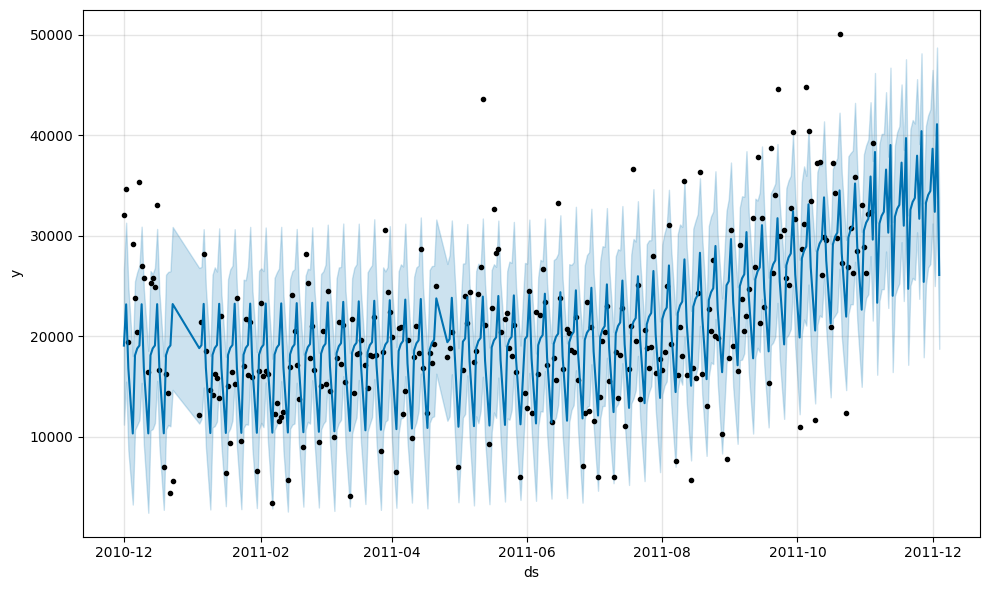

In [40]:
# summarize the forecast
print('Printing outputs from Prophet prediction...\n', forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

# plot forecast
prophet.plot(forecast)
plt.show()

Let's evaluate the model prediction now

In [42]:
#y_true .rt\
print('Length of forcast series, train series, and original series: ', len(forecast), len(train), len(df3))
print(' ')
y_true= test['y'].values
y_pred = forecast['yhat'][-len(y_true):].values
mae = mean_absolute_error(y_true, y_pred)
print('Mean Absolute Error: %.3f' % mae)

Length of forcast series, train series, and original series:  305 275 305
 
Mean Absolute Error: 7945.402


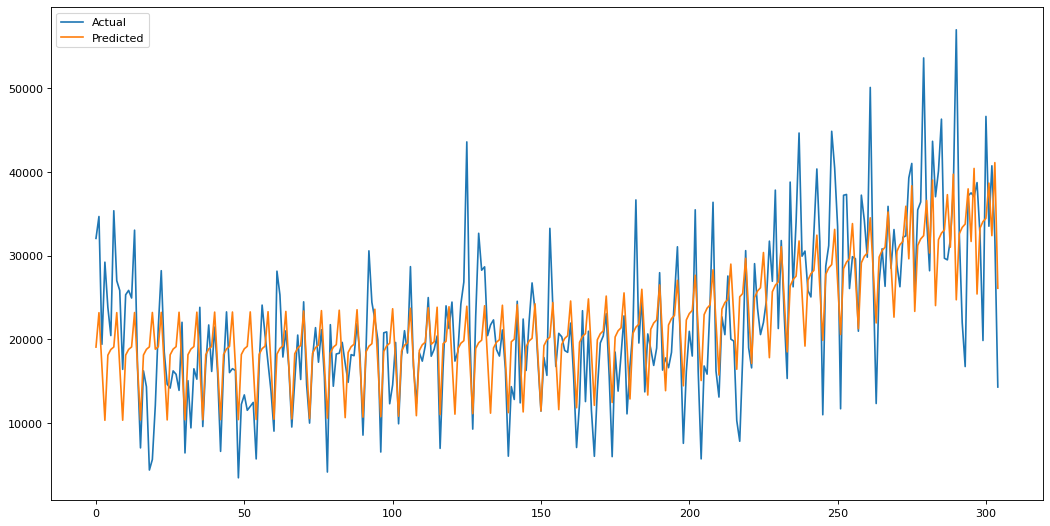

In [44]:
# plot expected vs actual
import matplotlib.pyplot as pltt
from matplotlib.pyplot import figure
figure(figsize=(16, 8), dpi=80)

plt.plot(df3['y'].values, label='Actual')
plt.plot(forecast['yhat'].values, label='Predicted')
plt.legend()
plt.show()

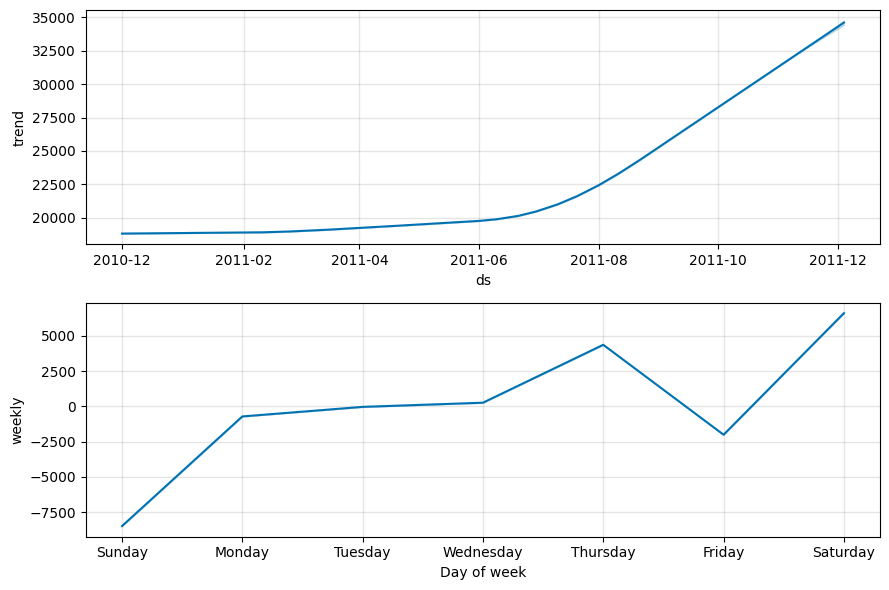

In [45]:
# plot the components of forcasted series
fig2 = prophet.plot_components(forecast)
plt.show()

In [46]:
# Now, let's use the built in fbprophet evaluation function and metrix
evaluation_model = cross_validation(prophet, initial='200 days', period='50 days', horizon = '25 days')

  0%|          | 0/3 [00:00<?, ?it/s]21:26:55 - cmdstanpy - INFO - Chain [1] start processing
21:26:55 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  2.90it/s]21:26:55 - cmdstanpy - INFO - Chain [1] start processing
21:26:55 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  3.65it/s]21:26:55 - cmdstanpy - INFO - Chain [1] start processing
21:26:55 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:00<00:00,  3.26it/s]


In [47]:
evaluation_metrics = performance_metrics(evaluation_model)
evaluation_metrics.head(5)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,2 days,3.036912e+07,5510.818580,4679.396174,0.336422,0.199525,0.268216,0.833333
1,3 days,1.485786e+07,3854.589140,3197.599698,0.153901,0.091402,0.145710,1.000000
2,4 days,1.421407e+07,3770.155585,3206.923302,0.129062,0.102577,0.130270,1.000000
3,5 days,8.964385e+06,2994.058331,2339.843313,0.099635,0.068918,0.098410,1.000000
4,6 days,6.363561e+06,2522.610000,2005.385819,0.101153,0.092280,0.096018,1.000000
